# COMBINED SVMs

markdown

In [22]:
resolution = "lowRES"   # choose from 'original' or 'lowRES'
score_command = "roc_curve"     # choose from "accuracy", "roc_curve", or "histograms"

In [23]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

In [32]:
def load_dpis(dpi_dir, label):
    files = [f for f in os.listdir(dpi_dir) if f.endswith('.npy')]
    data = []
    targets = []
    
    for file in files:
        dpi = np.load(os.path.join(dpi_dir, file), allow_pickle=True)
        data.append(np.ravel(dpi)) #flattening dpi
        targets.append(label)
        
    return data, targets


def trainSVM(resolution="original"):
    
    results = {}
    
    GRBdpidir = {"original": "GRBdpi", "lowRES": "GRBdpi_lowRES"}
    GLITCHdpidir = {"original": os.path.expanduser("~/scratch/GLITCHdpi"), "lowRES": os.path.expanduser("~/scratch/GLITCHdpi_lowRES")}

    print(f"\n\nTraining with {resolution} SVM resolution...")
    
    GRBdir = GRBdpidir[resolution]
    GLITCHdir = GLITCHdpidir[resolution]
    
    grb_data, grb_targets = load_dpis(GRBdir, "GRB")
    glitch_data, glitch_targets = load_dpis(GLITCHdir, "GLITCH")

    data = np.array(grb_data + glitch_data)
    targets = np.array(grb_targets + glitch_targets)
    
    print(f"Data shape: {data.shape}")
    print(f"Targets shape: {targets.shape}")

    
    
    # Support Vector Model here
    clf = svm.SVC(probability=True)
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, shuffle=True, stratify=targets)
    
    clf.fit(X_train, y_train)
    
    # SAVING SVM
    model_name = f"smv_{resolution}_model2.0.pkl"
    with open(model_name, "wb") as f:
        pickle.dump(clf, f)
        
    # dictionary    
    #classifiers[resolution] = clf

    predicted = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)

    class_indices = {cls: idx for idx, cls in enumerate(clf.classes_)}

    results[resolution] = {
        "clf": clf,
        "X_test": X_test,
        "y_test": y_test,
        "predicted": predicted,
        "probabilities": probabilities,
        "class_indices": class_indices
    }
    
    
    # Print predictions and confidence for a few test samples
    for i in range(len(X_test)):
        print(f"\nTest {i+1}:")
        print(f"Predicted: {predicted[i]}")
        print(f"REAL: {y_test[i]}")
        predicted_class_index = class_indices[predicted[i]]
        print(f"Confidence in predicted class: {probabilities[i][predicted_class_index]:.4f}")
        print("_" * 42)
        
    return results


def visualize(results, score_command = "accuracy", resolution = "original"):
    clf = results["clf"]
    X_test = results["X_test"]
    y_test = results["y_test"]
    predicted = results["predicted"]
    probabilities = results["probabilities"]
    class_indices = results["class_indices"]
    
    if score_command == "accuracy":
        accuracy = np.mean(predicted == y_test)
        print(f"\nModel accuracy ({resolution}): {accuracy:.2f}")

    elif score_command == "roc_curve":
        positiveclass_is1 = class_indices['GLITCH']
        y_score = probabilities[:, positiveclass_is1]
        y_test_is1 = [1 if label == 'GLITCH' else 0 for label in y_test]

        RocCurveDisplay.from_predictions(y_test_is1, y_score)
        plt.title(f"ROC Curve ({resolution}, Positive Class: 'GLITCH')")
        plt.show()

    elif score_command == "histograms":
        glitch_index = class_indices["GLITCH"]
        grb_index = class_indices["GRB"]

        bin_edges = np.linspace(0, 1, 17)
        
        bl = y_test == "GLITCH"
        plt.hist(probabilities[:, glitch_index][bl], bins=bin_edges, alpha=0.5, label="GLITCH")
        
        bl = y_test == "GRB"
        plt.hist(probabilities[:, grb_index][bl], bins=bin_edges, alpha=0.5, label="GRB")
        
        plt.title(f"{resolution} SVM Confidence Level Histogram")
        plt.legend()
        plt.show()

    else:
        print("Invalid score_command. Choose from: 'accuracy', 'roc_curve', or 'histograms'")
    

### main and score calling

In [33]:
def main(resolution="original", score_command="accuracy"):
    all_results = trainSVM(resolution=resolution)
    results = all_results[resolution]
    visualize(results, score_command=score_command, resolution=resolution)



Training with lowRES SVM resolution...
Data shape: (502, 512)
Targets shape: (502,)

Test 1:
Predicted: GRB
REAL: GRB
Confidence in predicted class: 0.9600
__________________________________________

Test 2:
Predicted: GRB
REAL: GLITCH
Confidence in predicted class: 0.2043
__________________________________________

Test 3:
Predicted: GLITCH
REAL: GLITCH
Confidence in predicted class: 0.9505
__________________________________________

Test 4:
Predicted: GRB
REAL: GRB
Confidence in predicted class: 0.9216
__________________________________________

Test 5:
Predicted: GLITCH
REAL: GLITCH
Confidence in predicted class: 0.9988
__________________________________________

Test 6:
Predicted: GRB
REAL: GRB
Confidence in predicted class: 0.8731
__________________________________________

Test 7:
Predicted: GLITCH
REAL: GLITCH
Confidence in predicted class: 0.9867
__________________________________________

Test 8:
Predicted: GLITCH
REAL: GLITCH
Confidence in predicted class: 1.0000
__________

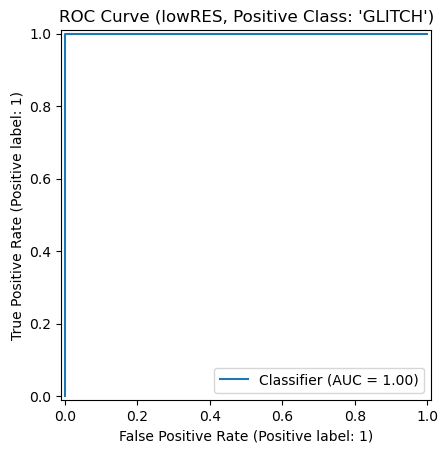

In [44]:
main(resolution=resolution, score_command=score_command)